# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
%%capture
!python -m pip install -r requirements.txt

## Imports

In [9]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

## Create train, validation and te

In [10]:
# Define transforms
transforms = transforms.ToTensor()

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transforms)

# Define the size of the validation set
validation_split = 0.2
train_size = int((1 - validation_split) * len(train_data))
validation_size = len(train_data) - train_size

# Split the dataset
train_subset, validation_subset = random_split(train_data, [train_size, validation_size])

# Define dataloaders
train_loader = DataLoader(train_subset, batch_size=100, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=100, shuffle=True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms)
test_loader = DataLoader(test_data, batch_size=100)

## Justify your preprocessing



###  The data needs to be converted to tensor so that deep learning models can ingest them.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [11]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [12]:
# Explore data
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("number of images: {}".format(images.shape))
print("number of labels: {}".format(labels.shape))

number of images: torch.Size([100, 1, 28, 28])
number of labels: torch.Size([100])


1


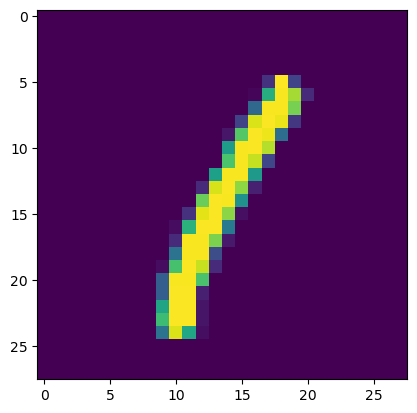

8


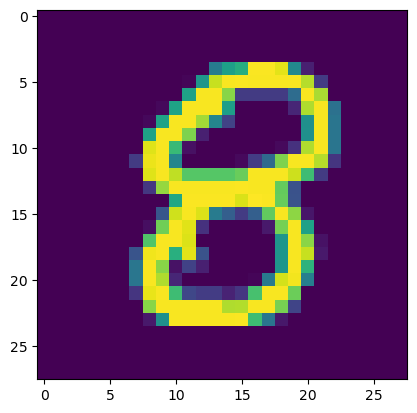

0


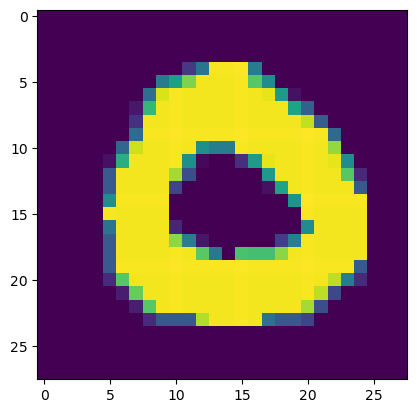

9


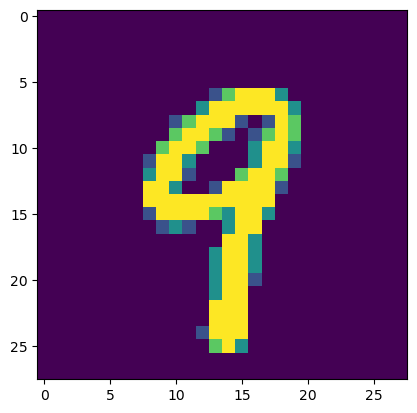

1


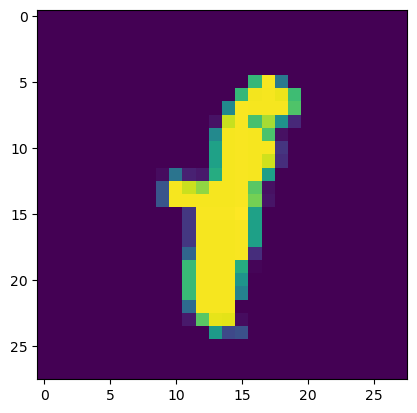

In [13]:
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [14]:
class Net(nn.Module):
    def __init__(self, dropout=False):
        super(Net, self).__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        self.use_dropout = dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        if self.use_dropout:
            x = self.dropout(x) 
        x = self.layer3(x)
        return x
    
net = Net(dropout=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [16]:

optimizer = optim.Adam(net.parameters(), lr=0.001)


criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [17]:
num_epochs = 15

# make lists to save the loss values
train_loss_history = list()
val_loss_history = list()

In [19]:
## YOUR CODE HERE ##

def train(net, num_epochs):
    for epoch in range(num_epochs):
        net = net.to(device)
        net.train()
        train_loss = 0.0
        train_correct = 0
        for i, data in enumerate(train_loader):
            # data is a list of [inputs, labels]
            inputs, labels = data
            
            inputs = inputs.to(device)
            # Zero out the gradients of the optimizer
            optimizer.zero_grad()

            # Get the outputs of your model and compute your loss
            outputs = net(inputs)
            outputs = outputs.cpu()

            loss = criterion(outputs, labels)

            # Compute the loss gradient using the backward method and have the optimizer take a step
            loss.backward()
            optimizer.step()

            # Compute the accuracy and print the accuracy and loss
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()
        print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
        train_loss_history.append(train_loss/len(train_loader))

        # The validation step is done for you.
        val_loss = 0.0
        val_correct = 0
        net.eval()
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            outputs = net(inputs)
            outputs = outputs.cpu()
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
        print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
        val_loss_history.append(val_loss/len(test_loader))

In [20]:
train(net, num_epochs)

Epoch 1 training accuracy: 88.72% training loss: 0.41945
Epoch 1 validation accuracy: 112.64% validation loss: 0.26172
Epoch 2 training accuracy: 94.85% training loss: 0.17520
Epoch 2 validation accuracy: 114.76% validation loss: 0.18134
Epoch 3 training accuracy: 96.31% training loss: 0.12219
Epoch 3 validation accuracy: 115.58% validation loss: 0.15213
Epoch 4 training accuracy: 97.23% training loss: 0.09151
Epoch 4 validation accuracy: 115.84% validation loss: 0.14025
Epoch 5 training accuracy: 97.74% training loss: 0.07299
Epoch 5 validation accuracy: 116.43% validation loss: 0.12534
Epoch 6 training accuracy: 98.16% training loss: 0.05937
Epoch 6 validation accuracy: 116.64% validation loss: 0.10974
Epoch 7 training accuracy: 98.42% training loss: 0.04927
Epoch 7 validation accuracy: 116.85% validation loss: 0.10540
Epoch 8 training accuracy: 98.80% training loss: 0.04006
Epoch 8 validation accuracy: 116.95% validation loss: 0.10966
Epoch 9 training accuracy: 98.97% training loss:

# Save the trained model

In [21]:
torch.save(net, "digit_classifier_1.pth")

Plot the training loss (and validation loss/accuracy, if recorded).

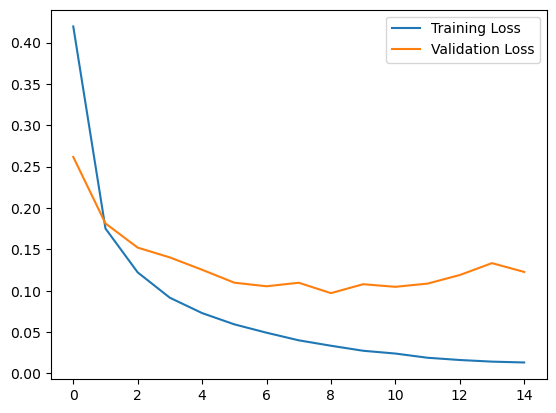

In [22]:
## YOUR CODE HERE ##
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [23]:
## YOUR CODE HERE ##
def test(net, test_loader, criterion):
    net = net.to('cpu')
    net.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_correct = 0
    with torch.no_grad():  # Disable gradient computation
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs.data, 1)
            test_correct += (preds == labels).sum().item()
            test_loss += loss.item()
    
    print(f'Test accuracy: {test_correct / len(test_loader.dataset):.2f}%')
    print(f'Test loss: {test_loss / len(test_loader):.5f}')


In [24]:
test(net, test_loader, criterion)

Test accuracy: 0.98%
Test loss: 0.09646


## Improving your model

Let's see if we can squeeze in more performance by adding `dropout` a  popular regularization technique.

In [25]:
net2 = Net(dropout=True)

In [26]:
train(net2, num_epochs)

Epoch 1 training accuracy: 8.77% training loss: 2.30784
Epoch 1 validation accuracy: 10.61% validation loss: 2.76873
Epoch 2 training accuracy: 8.85% training loss: 2.30798
Epoch 2 validation accuracy: 10.61% validation loss: 2.76873
Epoch 3 training accuracy: 8.81% training loss: 2.30778
Epoch 3 validation accuracy: 10.61% validation loss: 2.76873
Epoch 4 training accuracy: 8.78% training loss: 2.30771
Epoch 4 validation accuracy: 10.61% validation loss: 2.76873
Epoch 5 training accuracy: 8.90% training loss: 2.30771
Epoch 5 validation accuracy: 10.61% validation loss: 2.76873
Epoch 6 training accuracy: 8.99% training loss: 2.30792
Epoch 6 validation accuracy: 10.61% validation loss: 2.76873
Epoch 7 training accuracy: 8.76% training loss: 2.30795
Epoch 7 validation accuracy: 10.61% validation loss: 2.76873
Epoch 8 training accuracy: 8.77% training loss: 2.30799
Epoch 8 validation accuracy: 10.61% validation loss: 2.76873
Epoch 9 training accuracy: 8.88% training loss: 2.30791
Epoch 9 

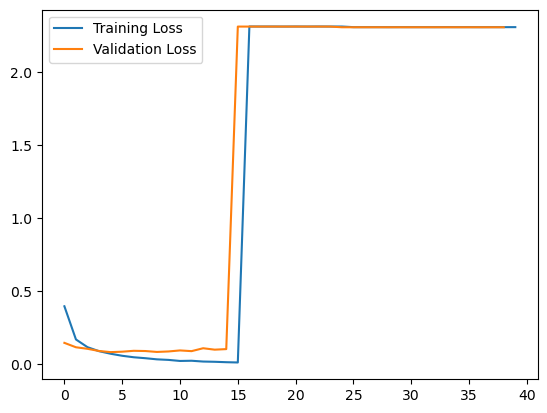

In [42]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

# Evaluate the test scores

In [43]:
test(net2, test_loader, criterion)

Test accuracy: 0.09%
Test loss: 2.30521


In [44]:
torch.save(net, "digit_classifier_2.pth")

## Conclusion
It seems our model performed better as in had `98%` test accuracy without regularization. So our best model is `digit_classifier_1.pt` in this case.